In [1]:
import os

import matplotlib.pyplot as plt
import torch
import torchdiffeq
from torchdyn.core import NeuralODE
from torchvision.transforms import ToPILImage
from torchvision.utils import make_grid
from tqdm import tqdm
import numpy as np
from collections import Counter

from torchcfm.conditional_flow_matching import *
from torchcfm.models.unet import UNetModel
from torchvision import datasets, transforms

# Load model
USE_TORCH_DIFFEQ = True
savedir = "models/cond_mnist"
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = UNetModel(
    dim=(1, 32, 32), num_channels=32, num_res_blocks=2, channel_mult=(2, 2, 2, 2), num_classes=10, class_cond=True
)
# use torch.load
model.load_state_dict(
    torch.load(os.path.join(savedir, "model.pth"), map_location=device, weights_only=True), strict=False
)
model.to(device)
node = NeuralODE(model, solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4)

def exponential_interval(a, b, n_points, exp_base=5.0) -> torch.Tensor:
    u = torch.linspace(0, 1, n_points)
    e_scaled = (exp_base ** u - 1) / (exp_base - 1)  # 标准化到 [0, 1]
    x = a + e_scaled * (b - a)
    return x

def integral(x_list, y_list, increase=True, x_init=0.0, x_final=1.0):
    # Compute the integral using the trapezoidal rule
    integral = 0.0
    for i in range(len(x_list) - 1):
        if x_list[i] < x_init or x_list[i + 1] > x_final:
            continue
        delta = (x_list[i + 1] - x_list[i]) * (y_list[i] + y_list[i + 1]) / 2
        if increase:
            integral += delta
        else:
            integral -= delta
    return integral

def compute_divergence(xt, t, cls, sample=10):
    batch_size = xt.shape[0]

    # Repeat inputs for vectorized sampling
    xt_rep = xt.repeat(sample, 1, 1, 1)
    cls_rep = cls.repeat(sample)
    
    
    vt = model.forward(t, xt_rep, cls_rep).view(-1, 1, 32, 32)
    noise = torch.randn_like(vt)

    dot = torch.sum(vt * noise, dim=(1, 2, 3))
    grad_vt = torch.autograd.grad(
        outputs=dot,
        inputs=xt_rep,
        grad_outputs=torch.ones_like(dot),
        create_graph=False,
        retain_graph=False
    )[0]

    divergence = torch.sum(grad_vt * noise, dim=(1, 2, 3))
    divergence = divergence.view(sample, batch_size).mean(dim=0)

    return divergence.detach().cpu().numpy()

def classifier(x, steps=2, sample=10):
    # Enumerate the classes
    x = x.repeat(10, 1, 1, 1)  # Shape: (1, 1, 32, 32)
    classes = torch.arange(10, device=device)
    # time_steps = exponential_interval(1, 0, steps, exp_base=100.0).to(device)  # Shape: (steps,)
    time_steps = torch.linspace(1, 0, steps).to(device)  # Shape: (steps,)
    # Reverse flow
    with torch.no_grad():
        if USE_TORCH_DIFFEQ:
            traj = torchdiffeq.odeint(
                lambda t, x: model.forward(t, x, classes),
                x,
                time_steps,
                atol=1e-4,
                rtol=1e-4,
                method="dopri5",
            )
        else:
            traj = node.trajectory(
                x,
                time_steps,
            )
    # Compute the initial log probability
    init = traj[-1].view(-1, 1, 32, 32)
    
    log_prob = -torch.sum(init ** 2, dim=(1, 2, 3)) / 2 - 0.5 * 32 * 32 * torch.log(torch.tensor(2 * np.pi, device=device))
    log_prob = log_prob.detach().cpu().numpy()

    # Compute the divergence
    div_list = []
    for i in range(steps):
        t = time_steps[i]
        xt = traj[i].view(-1, 1, 32, 32)
        xt.requires_grad_(True)
        div = compute_divergence(xt, t, classes, sample=sample)
        div_list.append(div)
      
    def log_prob_func(t):
        return log_prob - integral(time_steps.cpu().numpy(), div_list, increase=False, x_init=0.0, x_final=t)
        
    # Analyze the log prob from 0 to 1
    log_prob_time_list = [log_prob_func(t) for t in time_steps.cpu().numpy()]
    
    plt.figure(figsize=(10, 6))
    for i in range(10):
        plt.plot(time_steps.cpu().numpy(), [log_prob_time_list[j][i] - log_prob_time_list[j].mean() for j in range(steps)], label=f"Class {i}")
    plt.xlabel("Time Step")
    plt.ylabel("Log Probability Deviation")
    plt.title("Log Probability Deviation Over Time for Each Class")
    plt.legend()
    plt.savefig("log_prob_over_time.png")
    plt.clf()
    prediction = np.argmax(log_prob_time_list, axis=1)
        
    return prediction, traj

Processing samples: 100%|██████████| 1/1 [01:15<00:00, 75.39s/it]

True label: 9


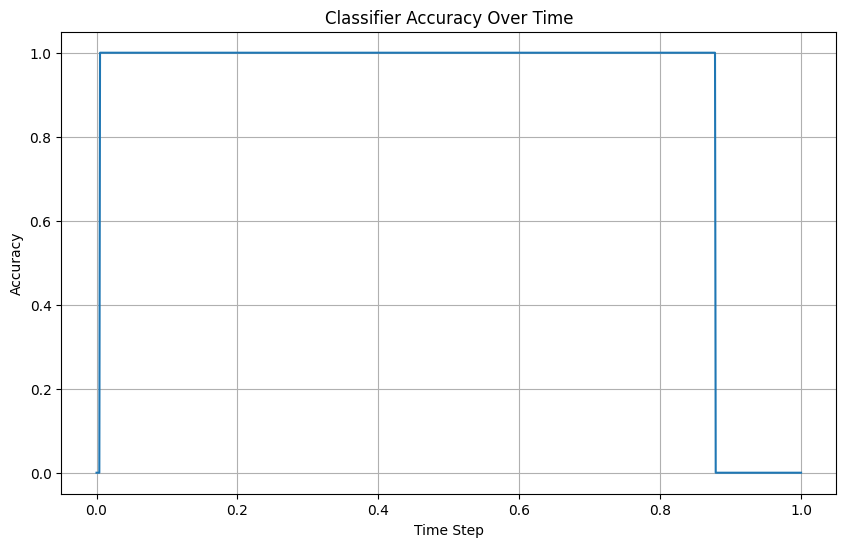

In [2]:
steps = 1000
num = 1
    
# Load MNIST dataset
transform = transforms.Compose([transforms.Pad(2),transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
mnist = datasets.MNIST(root="data", train=False, download=True, transform=transform)

# Select 1 sample image and label pairs
sample_indices = np.random.choice(len(mnist), num, replace=False)
samples = [mnist[i] for i in sample_indices]
acc_num_time_list = [0 for _ in range(steps)]

with tqdm(samples, desc="Processing samples") as pbar:
    for i, (img, label) in enumerate(pbar):
        img = img.unsqueeze(0).to(device)
        prediction_time_list, traj = classifier(img, steps=steps, sample=20)
        print("True label:", label)
        # Count the number of correct predictions at each time step
        acc_num_time_list = [acc_num_time_list[j] + (prediction_time_list[j] == label) for j in range(steps)]
    # Calculate the accuracy at each time step
acc_time_list = [acc_num / len(samples) for acc_num in acc_num_time_list]
plt.plot(np.linspace(1, 0 , steps), acc_time_list)
plt.xlabel("Time Step")
plt.ylabel("Accuracy")
plt.title("Classifier Accuracy Over Time")
plt.grid()
plt.savefig("classifier_accuracy.png")


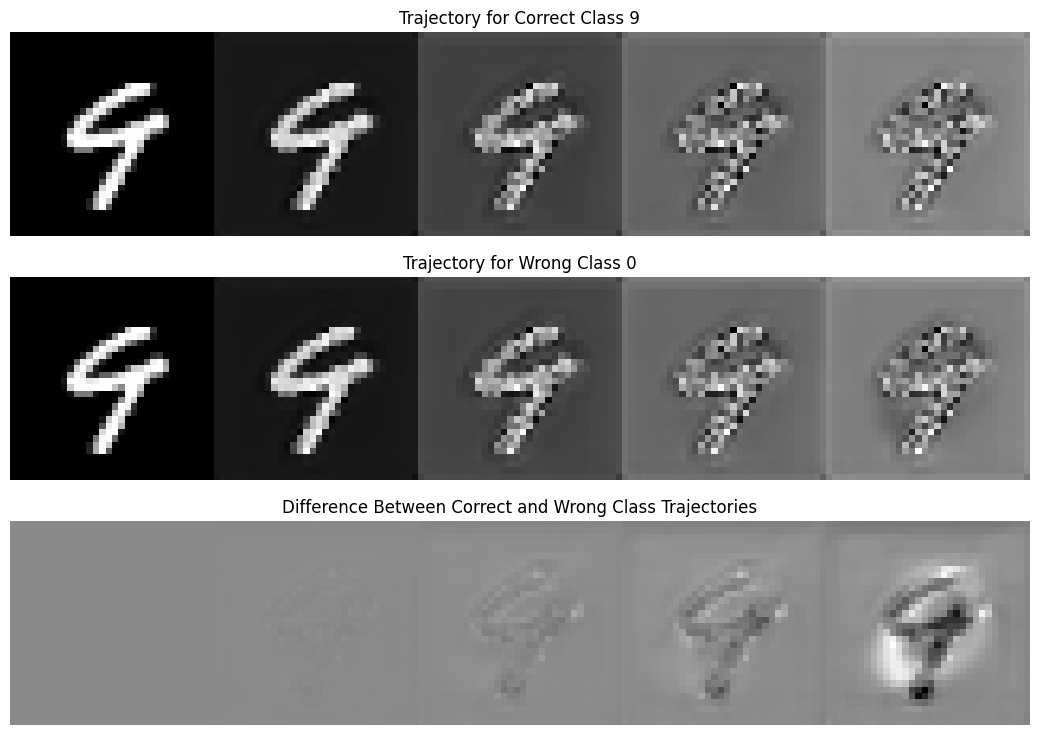

In [7]:
# Visualize the trajectory of the correct label, show 5 images for each trajectory, the interval of time step should be the same
def visualize_trajectory(traj, label, wrong_label, steps=1000):
    traj = traj.cpu().numpy()
    num_images = 5
    selected_indices = np.linspace(0, steps - 1, num_images, dtype=int)
    
    # Correct label trajectory
    correct_images = [traj[idx][label][0] for idx in selected_indices]
    correct_grid = make_grid([torch.tensor(img).unsqueeze(0) for img in correct_images], nrow=num_images, padding=0, normalize=True, scale_each=True)
    
    # Wrong label trajectory
    wrong_images = [traj[idx][wrong_label][0] for idx in selected_indices]
    wrong_grid = make_grid([torch.tensor(img).unsqueeze(0) for img in wrong_images], nrow=num_images, padding=0, normalize=True, scale_each=True)
    
    plt.figure(figsize=(15, 9))
    
    # Plot correct label trajectory
    plt.subplot(3, 1, 1)
    plt.imshow(ToPILImage()(correct_grid), cmap='gray')
    plt.title(f"Trajectory for Correct Class {label}")
    plt.axis('off')
    
    # Plot wrong label trajectory
    plt.subplot(3, 1, 2)
    plt.imshow(ToPILImage()(wrong_grid), cmap='gray')
    plt.title(f"Trajectory for Wrong Class {wrong_label}")
    plt.axis('off')
    
    # Plot difference
    difference = np.array(correct_images) - np.array(wrong_images)
    difference_grid = make_grid([torch.tensor(img).unsqueeze(0) for img in difference], nrow=num_images, padding=0, normalize=True)
    plt.subplot(3, 1, 3)
    plt.imshow(ToPILImage()(difference_grid), cmap='gray')
    plt.title("Difference Between Correct and Wrong Class Trajectories")
    plt.axis('off')
    
    
    
    plt.savefig(f"trajectory_class_{label}_vs_{wrong_label}.png")
    plt.show()

# Assuming the wrong label is different from the true label
wrong_label = (label + 1) % 10  # Example: pick the next class as the wrong label
visualize_trajectory(traj, label, wrong_label, steps=steps)